# Support Vector Machines

In [1]:
import numpy as np
import pickle as pkl
from scipy import optimize
from scipy.linalg import cho_factor, cho_solve
import matplotlib.pyplot as plt
import scipy



## Loading the data

The file 'classification_datasets' contains 3 small classification datasets:
    
    - dataset_1: mixture of two well separated gaussians
    - dataset_2: mixture of two gaussians that are not separeted
    - dataset_3: XOR dataset that is non-linearly separable.
   
Each dataset is a hierarchical dictionary with the following structure:
        
        dataset = {'train': {'x': data, 'y':label}
                    'test': {'x': data, 'y':label}
                  }
The data $x$ is an $N$ by $2$ matrix, while the label $y$ is a vector of size $N$. 

Only the third dateset is used. 

In [2]:
# file = open('datasets/classification_datasets', 'rb')
# datasets = pkl.load(file)
# file.close()
# dataset = datasets['dataset_3']

# fig, ax = plt.subplots(1,1, figsize=(5, 5))
# plotClassification(dataset['train']['x'], dataset['train']['y'], ax=ax)


## III- Kernel SVC 
### 1- Implementing the Gaussian Kernel
Implement the method 'kernel' of the class RBF below, which takes as input two data matrices $X$ and $Y$ of size $N\times d$ and $M\times d$ and returns a gramm matrix $G$ of shape $N\times M$ whose components are $k(x_i,y_j) = \exp(-\Vert x_i-y_i\Vert^2/(2\sigma^2))$. (The fastest solution does not use any for loop!)

In [3]:
class RBF:
    def __init__(self, sigma=1.):
        self.sigma = sigma  ## the variance of the kernel
    def kernel(self,X,Y):
        ## Input vectors X and Y of shape Nxd and Mxd
        # return np.exp( -np.sum( (X[...,:,None,:] - Y[...,None,:,:])**2, axis = 2 )/(2.0*self.sigma) )
        
        N = X.shape[0]
        M = Y.shape[0]
        return np.exp( - ( np.sum(X**2, axis = -1) + np.sum(Y**2, axis = -1) - 2*np.einsum('ij,kj->', X,Y)  )/(2.0*self.sigma) )


### 2- Implementing the classifier
Implement the methods 'fit' and 'separating_function' of the class KernelSVC below to learn the Kernel Support Vector Classifier.

In [4]:
class KernelSVC:
    
    def __init__(self, C, kernel, epsilon = 1e-3):
        self.type = 'non-linear'
        self.C = C                               
        self.kernel = kernel        
        self.alpha = None
        self.y = None
        self.support = None
        self.epsilon = epsilon
        self.norm_f = None
       
    
    def fit(self, X, y):
       #### You might define here any v ariable needed for the rest of the code
        N = len(y)
        self.y = y
        self.X = X
        self.support = None
        K = self.kernel(X,X)
        # Lagrange dual problem
        def loss(alpha):
            beta = y*alpha
            return 0.5*beta.reshape((1,-1))@K@beta - np.sum(alpha)  #'''--------------dual loss ------------------ '''

        # Partial derivate of Ld on alpha
        def grad_loss(alpha): # REVOIR !
            beta = y*alpha
            return (np.diag(y)@K@beta).flatten() - np.ones(alpha.shape) # '''----------------partial derivative of the dual loss wrt alpha -----------------'''


        # Constraints on alpha of the shape :
        # -  d - C*alpha  = 0
        # -  b - A*alpha >= 0
        
        fun_eq = lambda alpha: np.dot(alpha,y)  # '''----------------function defining the equality constraint------------------'''        
        jac_eq = lambda alpha: y   #'''----------------jacobian wrt alpha of the  equality constraint------------------'''
        fun_ineq = lambda alpha: np.concatenate( ( alpha , self.C - alpha ) , axis = 0 )  # '''---------------function defining the inequality constraint-------------------'''     
        jac_ineq = lambda alpha: np.concatenate( (np.eye(N), -np.eye(N) ) , axis = 0 )  # '''---------------jacobian wrt alpha of the  inequality constraint-------------------'''
        
        constraints = ({'type': 'eq',  'fun': fun_eq, 'jac': jac_eq},
                       {'type': 'ineq', 
                        'fun': fun_ineq , 
                        'jac': jac_ineq})

        optRes = optimize.minimize(fun=lambda alpha: loss(alpha),
                                   x0=np.ones(N), 
                                   method='SLSQP', 
                                   jac=lambda alpha: grad_loss(alpha), 
                                   constraints=constraints)
        self.alpha = optRes.x
        
        ## Assign the required attributes
        indices = np.nonzero( (self.alpha > self.epsilon)*( self.alpha < C - self.epsilon) )[0]
        self.support = X[indices]  #'''------------------- A matrix with each row corresponding to a point that falls on the margin ------------------'''
        print(self.support)
        self.b = y[indices[0]] - K[indices[0]]@(self.alpha*y) #''' -----------------offset of the classifier------------------ '''
        self.b = np.mean(y[indices] - K[indices]@(self.alpha*y)) #''' -----------------offset of the classifier------------------ '''

        beta = y*self.alpha
        self.norm_f = beta.reshape((1,-1))@K@beta  # '''------------------------RKHS norm of the function f ------------------------------'''


    ### Implementation of the separting function $f$ 
    def separating_function(self,x):
        # Input : matrix x of shape N data points times d dimension
        # Output: vector of size N
        output = (self.alpha*self.y).reshape((1,-1))@kernel(self.X,x)
        return output.flatten()
    
    
    def predict(self, X):
        """ Predict y values in {-1, 1} """
        d = self.separating_function(X)
        return 2 * (d+self.b> 0) - 1

### 2- Fitting the classifier

Run the code block below to fit the classifier and report its output.

In [5]:
sigma = 1.5
C=100.
kernel = RBF(sigma).kernel
model = KernelSVC(C=C, kernel=kernel)
train_dataset = datasets['dataset_3']['train']
model.fit(train_dataset['x'], train_dataset['y'])
plotClassification(train_dataset['x'], train_dataset['y'], model, label='Training')

NameError: name 'datasets' is not defined

# Kernel Regression

## Loading the data

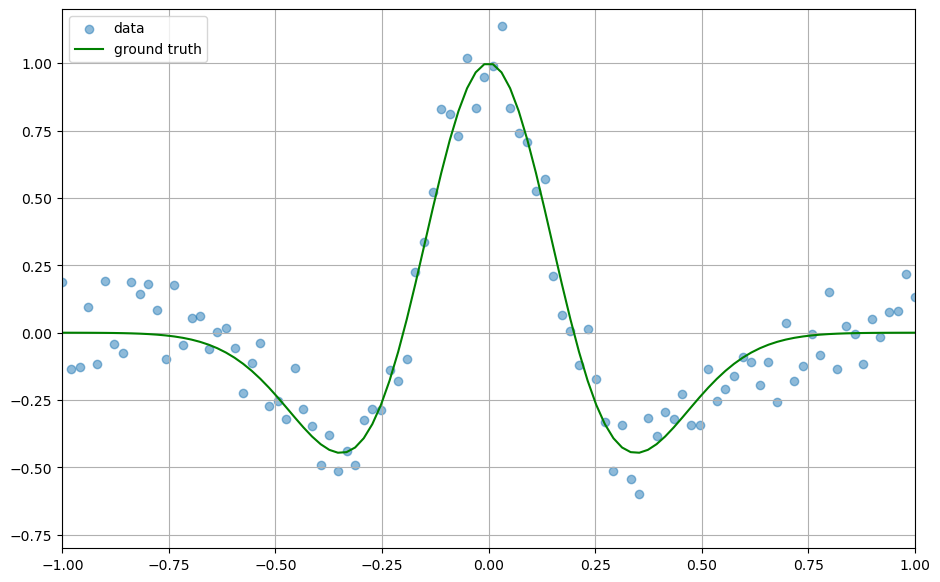

In [ ]:
file = open('datasets/regression_datasets', 'rb')
datasets = pkl.load(file)
file.close()
train_set = datasets['dataset_1']['train']
train_set = datasets['dataset_1']['test']
plotRegression(train_set['x'], train_set['y'],Y_clean= train_set['y_clean'])


## Kernel Ridge Regression
### 1- Implementing the regressor
Implement the method 'fit' of the classes KernelRR and MultivariateKernelRR below to perform Kernel Ridge Regression. 


In [ ]:
class KernelRR:

    def __init__(self,kernel,lmbda):
        self.lmbda = lmbda                    
        self.kernel = kernel    
        self.alpha = None 
        self.b = None
        self.support = None
        self.type='ridge'

    def fit(self, X, y):
        self.support = X
        self.b = 
        self.alpha =         

    ### Implementation of the separting function $f$ 
    def regression_function(self,x):
        # Input : matrix x of shape N data points times d dimension
        # Output: vector of size N
        return 


    def predict(self, X):
        """ Predict y values in {-1, 1} """
        return regression_function(X)+self.b


class MultivariateKernelRR:      
    def __init__(self,kernel,lmbda):
        self.lmbda = lmbda                    
        self.kernel = kernel
        self.support = None
        self.alpha = None
        self.b = None
        self.type='ridge'

    def fit(self, X, y):
        self.support = X
        self.b = 
        self.alpha =  

    ### Implementation of the separting function $f$ 
    def regression_function(self,x):
        # Input : matrix x of shape N data points times d dimension
        # Output: vector of size N
        return 

    def predict(self, X):
        """ Predict y values in {-1, 1} """
        return self.regression_function(X)+np.expand_dims(self.b,axis=0)


### 2- Fitting the regressor

Run the code block below to fit the regressor and report its output.

In [ ]:
# sigma = 0.2
# lmbda = .1
# kernel = RBF(sigma).kernel
model = KernelRR(kernel, lmbda=lmbda)
# model.fit(train_set['x'].reshape(-1,1),train_set['y'])
# plotRegression(train_set['x'], train_set['y'], Y_clean= train_set['y_clean'], model=model, label='Train')

# Kernel PCA

### 1- Implementing kernel PCA
Implement the method 'fit' of the classes KernelSVR below to perform Kernel Support Vector Regression. 

In [ ]:
class KernelPCA:
    
    def __init__(self,kernel, r=2):                             
        self.kernel = kernel          # <---
        self.alpha = None # Matrix of shape N times d representing the d eingenvectors alpha corresp
        self.lmbda = None # Vector of size d representing the top d eingenvalues
        self.support = None # Data points where the features are evaluated
        self.r =r ## Number of principal components
    def compute_PCA(self, X):
        # assigns the vectors
        self.support = X
        N = X.shape[0]
        K = kernel(X,X)
        G = K - 1.0/N*np.ones((N,N))@K - 1.0/N*K@np.ones((N,N)) + 1.0/N**2*np.ones((N,N))@K@np.ones((N,N))
        lmbda, alpha = np.linalg.eigh(G)
        lmbda = lmbda[::-1]
        alpha = alpha[:, ::-1]
        
#         lmbda, alpha = np.real(lmbda), np.real(alpha)
        
#         alpha = alpha/np.sqrt( np.einsum("ij,j",[alpha.T@G@alpha ) )
        print("alpha", alpha.shape)
        print('lbda', lmbda)
        self.lmbda = lmbda[0:self.r]
        self.alpha = alpha[:,0:self.r]
        for j in range(self.r) :
            self.alpha[:,j] = self.alpha[:,j]/np.sqrt(self.alpha[:,j].reshape((1,-1))@G@self.alpha[:,j].reshape((-1,1)) )
        print('r',self.r)
        print("qsdfqsdfqsdfqsd", self.alpha.shape)
        
        #constraints = ({})
        # Maximize by minimizing the opposite
        
    def transform(self,x):
        # Input : matrix x of shape N data points times d dimension
        # Output: vector of size N
        K = self.kernel(self.support, x)
        N1, N2 = K.shape
        reponse = K - np.ones((N1,N1))/N1@K \
                 - K@np.ones((N2,N2))/N2 +  np.ones((N1,N1))/N1@K@np.ones((N2,N2))/N2
        return( reponse.T@self.alpha )
    


### 2- Performing kernel PCA

Run the code block below apply a kernel PCA to a dataset consisting of three concentric rings and report the output. What can you conclude about this dataset?

alpha (100, 100)
lbda [ 1.69819553e+01  1.54269487e+01  7.15403875e+00  5.18176038e+00
  4.76221470e+00  1.49023436e+00  1.33953221e+00  1.02649473e+00
  9.34189125e-01  3.27563805e-01  3.14542827e-01  1.60820064e-01
  1.48531860e-01  1.07131649e-01  6.63240603e-02  5.80473576e-02
  2.12691020e-02  1.77596181e-02  1.41268790e-02  1.24545551e-02
  1.02177551e-02  7.81432568e-03  2.07421901e-03  1.69902985e-03
  1.46048982e-03  1.40492496e-03  7.70703410e-04  6.53676845e-04
  2.45044811e-04  2.01308510e-04  1.22223610e-04  9.33597847e-05
  2.53512904e-05  2.03396230e-05  1.85509834e-05  1.78932349e-05
  9.51324238e-06  7.46462490e-06  2.43735218e-06  7.41149411e-07
  6.51235887e-07  5.80116836e-07  4.39877355e-07  2.89820598e-07
  1.25421418e-07  3.24474783e-08  2.01352638e-08  1.14275898e-08
  9.02889206e-09  6.27841808e-09  5.36764642e-09  2.93917513e-09
  9.44388393e-10  3.06718666e-10  2.72210846e-10  1.60607407e-10
  1.48411188e-10  7.25228862e-11  2.20559681e-11  1.28531115e-11
  6

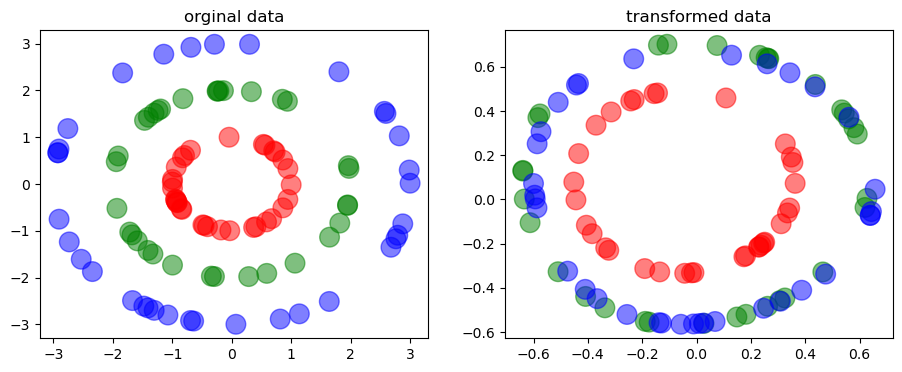

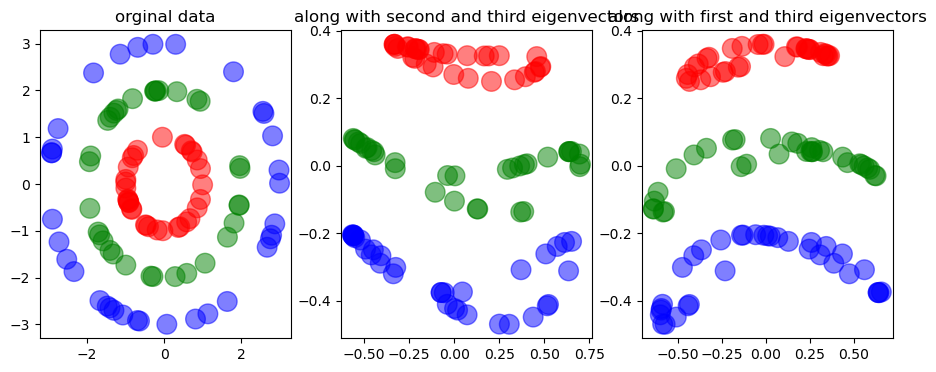

In [ ]:
file = open('datasets/pca_datasets', 'rb')
datasets = pkl.load(file)
file.close()
train_set = datasets['dataset_1']['train']
test_set = datasets['dataset_1']['test']

sigma = 4.
kernel = RBF(sigma).kernel
pca = KernelPCA(kernel, r=3 )
pca.compute_PCA(train_set['x'])
pca_components = pca.transform(test_set['x'])

fig, ax = plt.subplots(1,2, figsize=(11, 4))
scatter_label_points(test_set['x'], test_set['y'], ax[0], title='orginal data')
scatter_label_points(pca_components[:,:2],test_set['y'], ax[1], title= 'transformed data')

fig, ax = plt.subplots(1,3, figsize=(11, 4))
scatter_label_points(test_set['x'], test_set['y'], ax[0], title='orginal data')
scatter_label_points(pca_components[:,1:3],test_set['y'], ax[1], title= 'along with second and third eigenvectors')
scatter_label_points(pca_components[:,::2],test_set['y'], ax[2], title= 'along with first and third eigenvectors')


# Denoising 
### 1- Implementing a denoiser based on Kernel PCA and Kernel Ridge Regression
Implement the methods 'fit' and 'denoise' of the classes Denoiser below. 

In [ ]:
class Denoiser:
    def __init__(self, kernel_encoder, kernel_decoder,dim_pca, lmbda):
        self.pca = KernelPCA(kernel_encoder, r=dim_pca)
        self.ridge_reg = MultivariateKernelRR(kernel_decoder, lmbda= lmbda)
    
    def fit(self,train):

        
    def denoise(self,test):
        
        return 

IndentationError: expected an indented block (34502054.py, line 9)

### 2- Denoising MNIST dataset

Run the code block below to perform denoising of a subset of MNIST digits dataset and report the output. To what extend the denoising is successful? How can it be improved?

In [ ]:
datasets = loadMNIST('datasets/SubsetMNIST')
clean_data = datasets['cleanMNIST']
data = datasets['noisyMNIST']


dim_pca =80
lmbda = 10.
sigma_encoder =8.
sigma_decoder =.5
kernel_encoder = RBF(sigma_encoder).kernel
kernel_decoder = RBF(sigma_decoder).kernel
denoiser = Denoiser(kernel_encoder,kernel_decoder,dim_pca, lmbda)

denoiser.fit(data['train'])
pred = denoiser.denoise(data['test'])

plot_multiple_images(clean_data['test'])
plot_multiple_images(data['test'])
plot_multiple_images(pred)